In [198]:
import requests
import json
import numpy as np
import pylab as pl
import collections
from matplotlib import collections  as mc
import matplotlib as  mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xmltodict, json
#get data
def get_data():
    #url = "http://overpass-api.de/api/interpreter?data=[out:json];(relation(31.206590021428738,120.46515178710938, 31.476357482874533,120.82220745117188)[%22route%22=%22subway%22];%3E;);out;"#suzhou
    url = "http://overpass-api.de/api/interpreter?data=[out:json];(relation(31.87108155373452,118.55800141308592, 32.21332031534233,118.91505707714842)[%22route%22=%22subway%22];%3E;);out;"#NanJing
    session = requests.Session()
    session.trust_env = False
    ss = session.get(url)
    da = ss.text
    #save raw data
    with open('data/data_nanjin.json','w') as f:
        f.write(da)
        
        
def plot_final(path, orignal_patrh):
    svg_file = open(path,'r')
    da = xmltodict.parse(svg_file.read())
    da = da['svg']['g']['circle']
    plot_da  = open(orignal_patrh,'r').read()
    plot_da = json.loads(plot_da)
    ways = dict()
    edges = plot_da['edges']
    for w in plot_da['lines']:
        ways[w['id']] = w
    nodes = {}
    for e in da:
        if '@cx' not in e:
            e['@cx'] = '0'
        if '@cy' not in e:
            e['@cy'] = '0'
        info = {
            'id':e['@data-id'],
            'label':e['@data-label'],
            'metadata':{
            'x': float(e['@cx']) ,
            'y':float(e['@cy']),
            },
            'r':e['@r']         
        }
        nodes[int(e['@data-id'])] = info
    # position adjust for label
    ## 斜向上四十五度角时放在下方，其余放在上方
    nodes_degree = {}
    for e in edges:
        s = e['source']
        t = e['target']
        if abs(nodes[t]['metadata']['x'] - nodes[s]['metadata']['x']) < 0.01:
            if nodes[s]['metadata']['y'] < nodes[t]['metadata']['y']:
                nodes_degree[s] = (1,0)
            else:
                nodes_degree[t] = (1,0)
        elif nodes[t]['metadata']['x'] - nodes[s]['metadata']['x'] < 0.01:
            mid = s
            s = t
            t = mid
            if abs(nodes[s]['metadata']['y'] - nodes[t]['metadata']['y']) < 0.01:
                nodes_degree[s] = (-1,1)

            elif nodes[s]['metadata']['y'] < nodes[t]['metadata']['y']:
                nodes_degree[s] = (1,-1)
            else:
                nodes_degree[s] = (1,1)
            nodes_degree[t] = (1,1)
        else:
            if abs(nodes[s]['metadata']['y'] - nodes[t]['metadata']['y']) < 0.01:
                nodes_degree[s] = (-1,1)
            elif nodes[s]['metadata']['y'] < nodes[t]['metadata']['y']:
                nodes_degree[s] = (1,-1)
            else:
                nodes_degree[s] = (1,1)
            nodes_degree[t] = (1,1)

    diff = nodes.keys() - nodes_degree.keys()
    for e in diff:
        nodes_degree[e] = (1,1)
    nodes_plot_da = {}
    ## plot 
    xx = []
    yy = []
    cc = []
    label_list = []
    for w in list(ways.values()):
        line = w['members']
        c = w['color']
        x_list = []
        y_list = []
        c_list = []
        i = 1
        for e in line:
            node = nodes[e]
            x = node['metadata']['x']
            y = node['metadata']['y']
            if e not in nodes_plot_da:
                nodes_plot_da[e] = [x,y,c, nodes[e]['label'], '']
            else:
                nodes_plot_da[e] = [x,y, c,nodes[e]['label'],'o']
            x_list.append(x)
            y_list.append(y)
        label_list.append(w['id'])
        xx.append(x_list)
        yy.append(y_list)
        cc.append(c)

    # edges
    mpl.rcParams[u'font.sans-serif'] = ['simhei']
    mpl.rcParams['axes.unicode_minus'] = False
    fig = plt.figure(figsize=[36,27])
    for i in range(len(xx)):
        x = xx[i]
        y = yy[i]
        plt.plot(x,y,color = cc[i], label = label_list[i], linewidth  = 8)

    for n in nodes_plot_da.keys():
        x,y,c,label,shape = nodes_plot_da[n]
        if shape == 'o':
            plt.scatter(x,y, color = 'white',edgecolors = 'black' ,s = 300,zorder=30)
        else:
            plt.scatter(x,y, color = c, s = 200,zorder= 30)
        x_modi, y_modi = nodes_degree[n]
        plt.text(x + 0.1*x_modi ,y+ 0.15 *y_modi , label,zorder= 50)

    plt.legend()
    return fig
def plot_original(path):
    plot_da  = open(path,'r').read()
    plot_da = json.loads(plot_da)
    nodes = dict()
    for t in plot_da['nodes']:
        nodes[t['id']] = t
    edges = plot_da['edges']
    ways = dict()
    for w in plot_da['lines']:
        ways[w['id']] = w

    nodes_plot_da = {}
    xx = []
    yy = []
    cc = []
    label_list = []
    for w in list(ways.values()):
        line = w['members']
        c = w['color']
        x_list = []
        y_list = []
        c_list = []
        i = 1
        for e in line:
            node = nodes[e]
            x = node['metadata']['x']
            y = node['metadata']['y']
            if e not in nodes_plot_da:

                nodes_plot_da[e] = [x,y,c, nodes[e]['label'], '']
            else:

                nodes_plot_da[e] = [x,y, c,nodes[e]['label'],'o']
            x_list.append(x)
            y_list.append(y)
        label_list.append(w['id'])
        xx.append(x_list)
        yy.append(y_list)
        cc.append(c)
    # edges
    mpl.rcParams[u'font.sans-serif'] = ['simhei']
    mpl.rcParams['axes.unicode_minus'] = False
    fig = plt.figure(figsize=[36,27])
    for i in range(len(xx)):
        x = xx[i]
        y = yy[i]
        plt.plot(x,y,color = cc[i], label = label_list[i], linewidth  = 3)

    for n in nodes_plot_da.keys():
        x,y,c,label,shape = nodes_plot_da[n]
        if shape == 'o':
            plt.scatter(x,y, color = 'white',edgecolors = 'black' ,s = 100,zorder=30)
        else:
            plt.scatter(x,y, color = c, s = 50,zorder= 30)
        plt.text(x  ,y , label,zorder= 50)
    plt.legend()
    return fig


In [199]:
################################################################################### structure data #########################################################################################
metro_data = open('data/data_suzhou.json','r').read()
metro_data = json.loads(metro_data)['elements']
node_info = {}
node_info_by_name = {}
for e in metro_data:
    if e['type'] == 'node' and 'tags' in e and 'name' in e['tags']:
        name = e['tags']['name']
        if name == '南京南':
            name = '南京南站'
        info = {
            'id':e['id'],
            'label':name,
            'metadata':{
                'x':e['lon']  ,
            'y':e['lat']
            }          
        }
        node_info[e['id']] = info
        node_info_by_name[name] = info
        
da = collections.defaultdict(list)
for e in metro_data:
    da[e['type']].append(e)
    
    
routine_info = {}
ways = {}
edges = collections.defaultdict(list)
useful_node = set()
aaa = 0

for e in da['relation']:
    name = e['tags']['name']
    name = name.split(':')[0]
    #name = "u" + name.split(' ')[2]
    if  name not in ways:
        mm = e['members']

        
        line = []
        for m in mm:
            if m['role'] == 'stop':
                line.append(m['ref'])
        for i in range(len(line)-1):
            info = {
                'source':node_info_by_name[node_info[line[i]]['label']]['id'],
                'target':node_info_by_name[node_info[line[i+1]]['label']]['id'],
                'relation':'subway',
                'metadata':{
                    'time':0,
                    'lines':[name]
                }
            
            }
            s = info['source']
            t = info['target']
            if (t,s) not in edges:
                edges[(s,t)].append(name)
            else:
                edges[(t,s)].append(name)
            if info['source'] not in useful_node:
                useful_node.add(info['source'])
            if info['target'] not in useful_node:
                useful_node.add(info['target'])
        line = [node_info_by_name[node_info[i]['label']]['id'] for i in line]
        ways[name] = {'id':name, 
                       #  'color': e['tags']['colour'], 
                       #'color': random_color(), 
                         'group': None,
                     'origin_id':e['id'],
                     'members':line}
## coloring
current_palette = sns.color_palette('hls',n_colors=len(ways.values()))
current_palette = current_palette.as_hex()      
ways_final = []
idd = 0
for w in ways.values():
    w.pop('origin_id')
    w['color'] = current_palette[idd]
    ways_final.append(w)
    idd += 1
    
edges_final = []
for k in edges.keys():
    s,t = k
    info = {
    'source':s,
    'target':t,
    'relation':'subway',
    'metadata':{
        'time':0,
        'lines':edges[k]
        }
     }
    edges_final.append(info)
nodes = dict()
for t in useful_node:
    nodes[t] = node_info[t]

final = {
    'nodes':list(nodes.values()),
    'edges':edges_final,
    'lines':ways_final
}
with open('data/structured_data.json','w') as f:
    f.write(json.dumps(final))

In [201]:
# solve MIP
import os
os.system("cd data/ &&  cat structured_data.json | transit-map > output.svg -t t && cd ..")

0

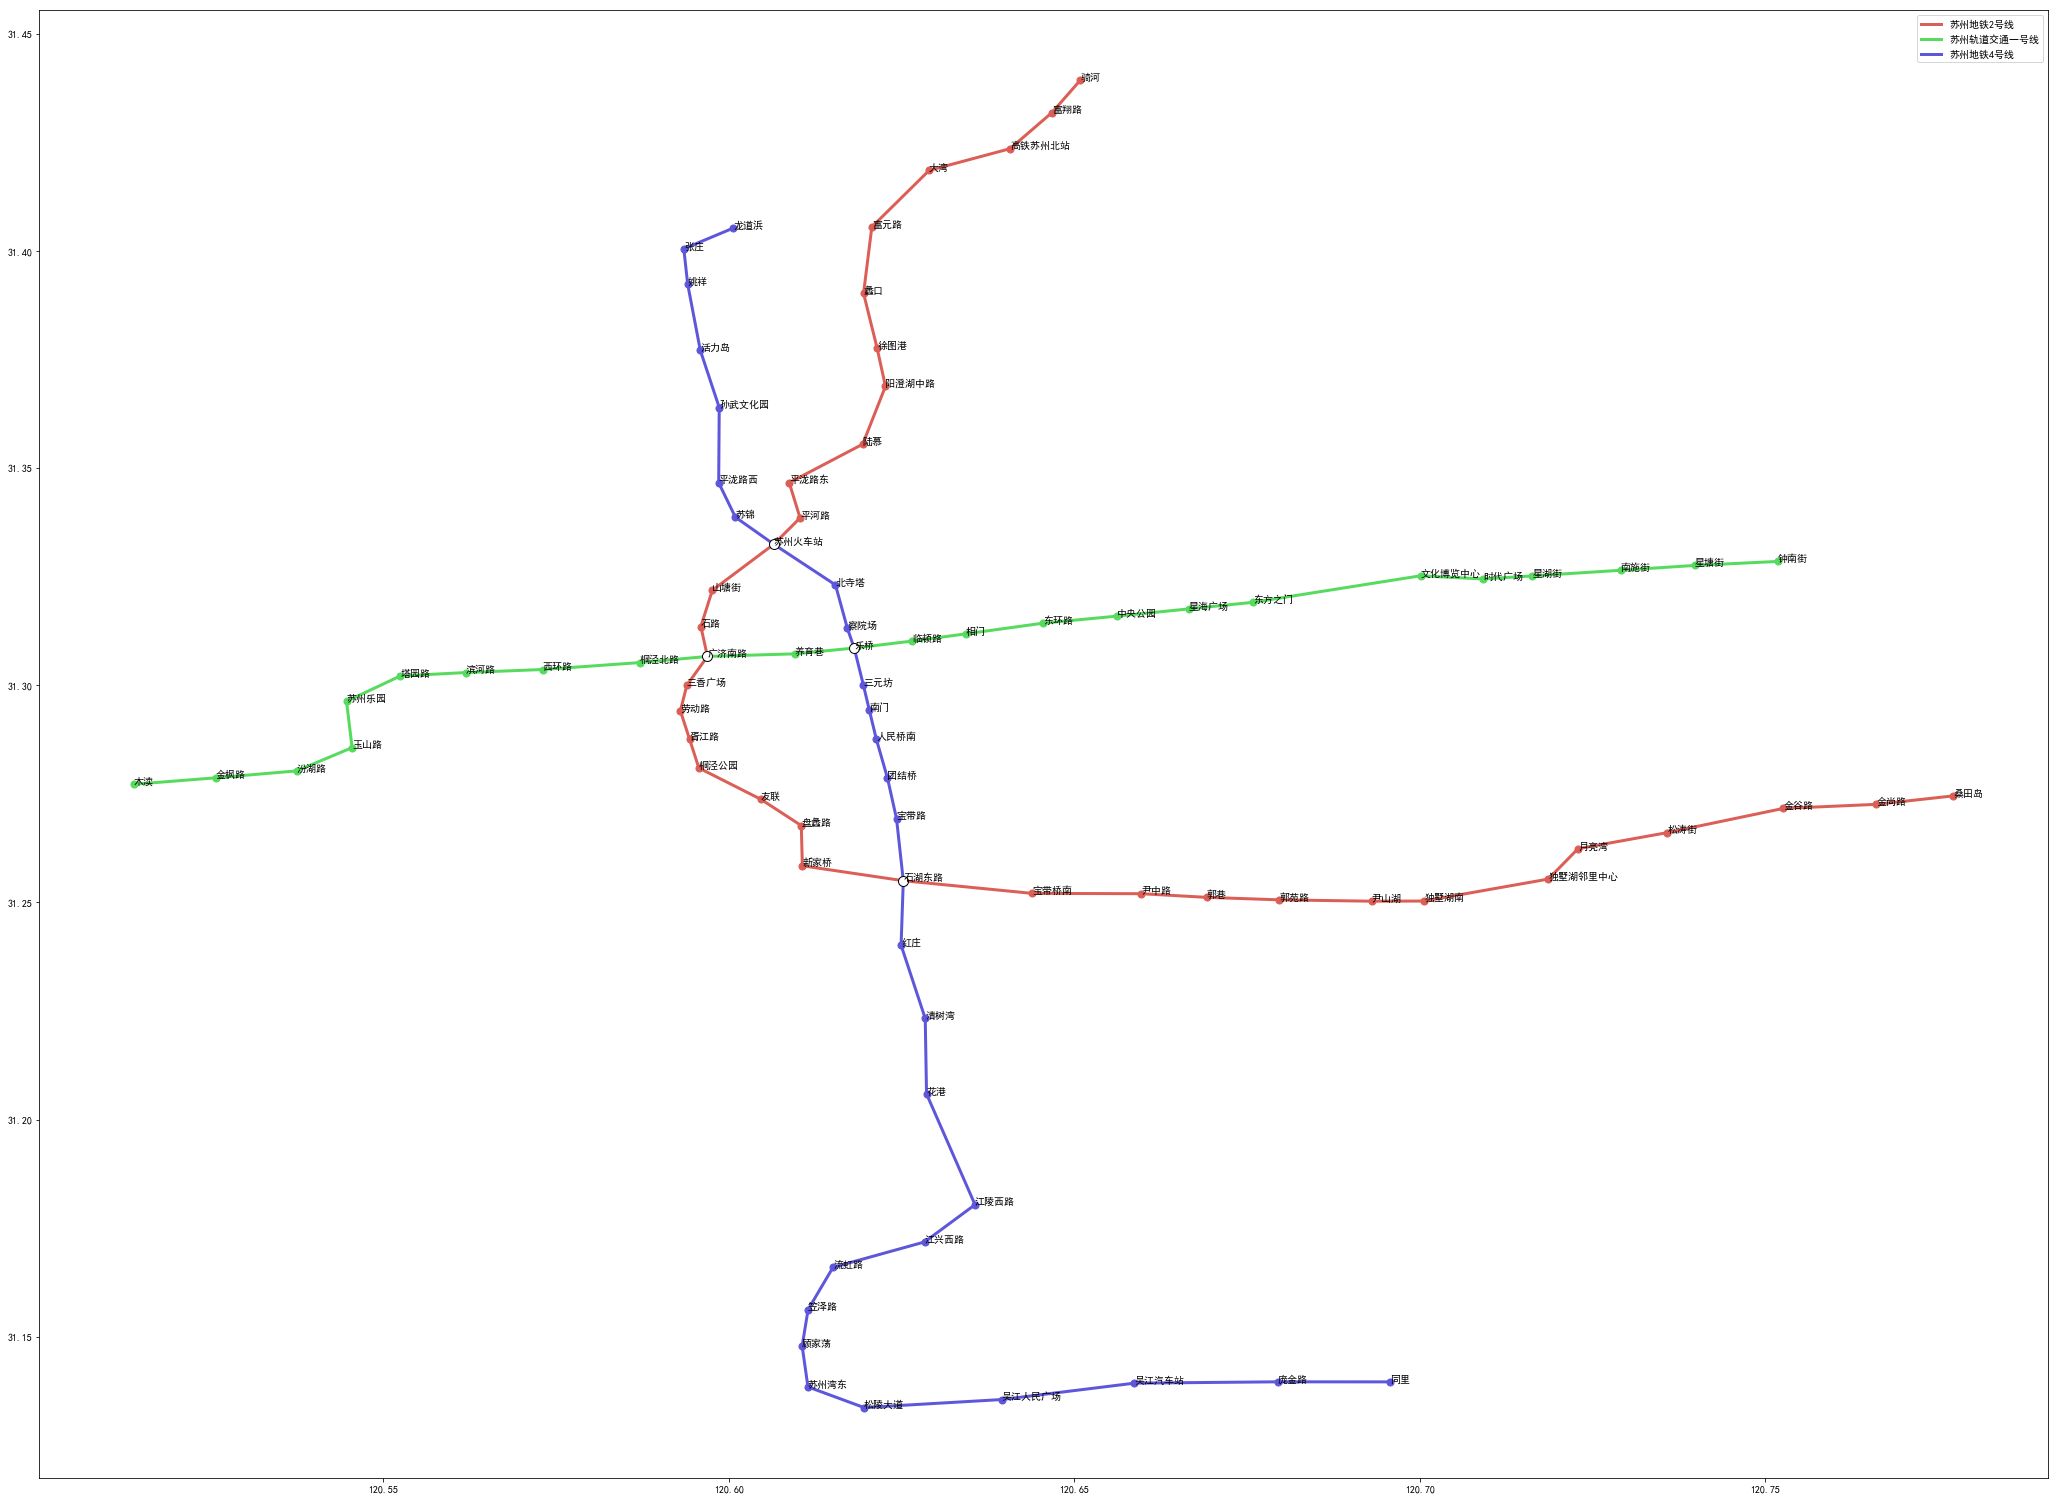

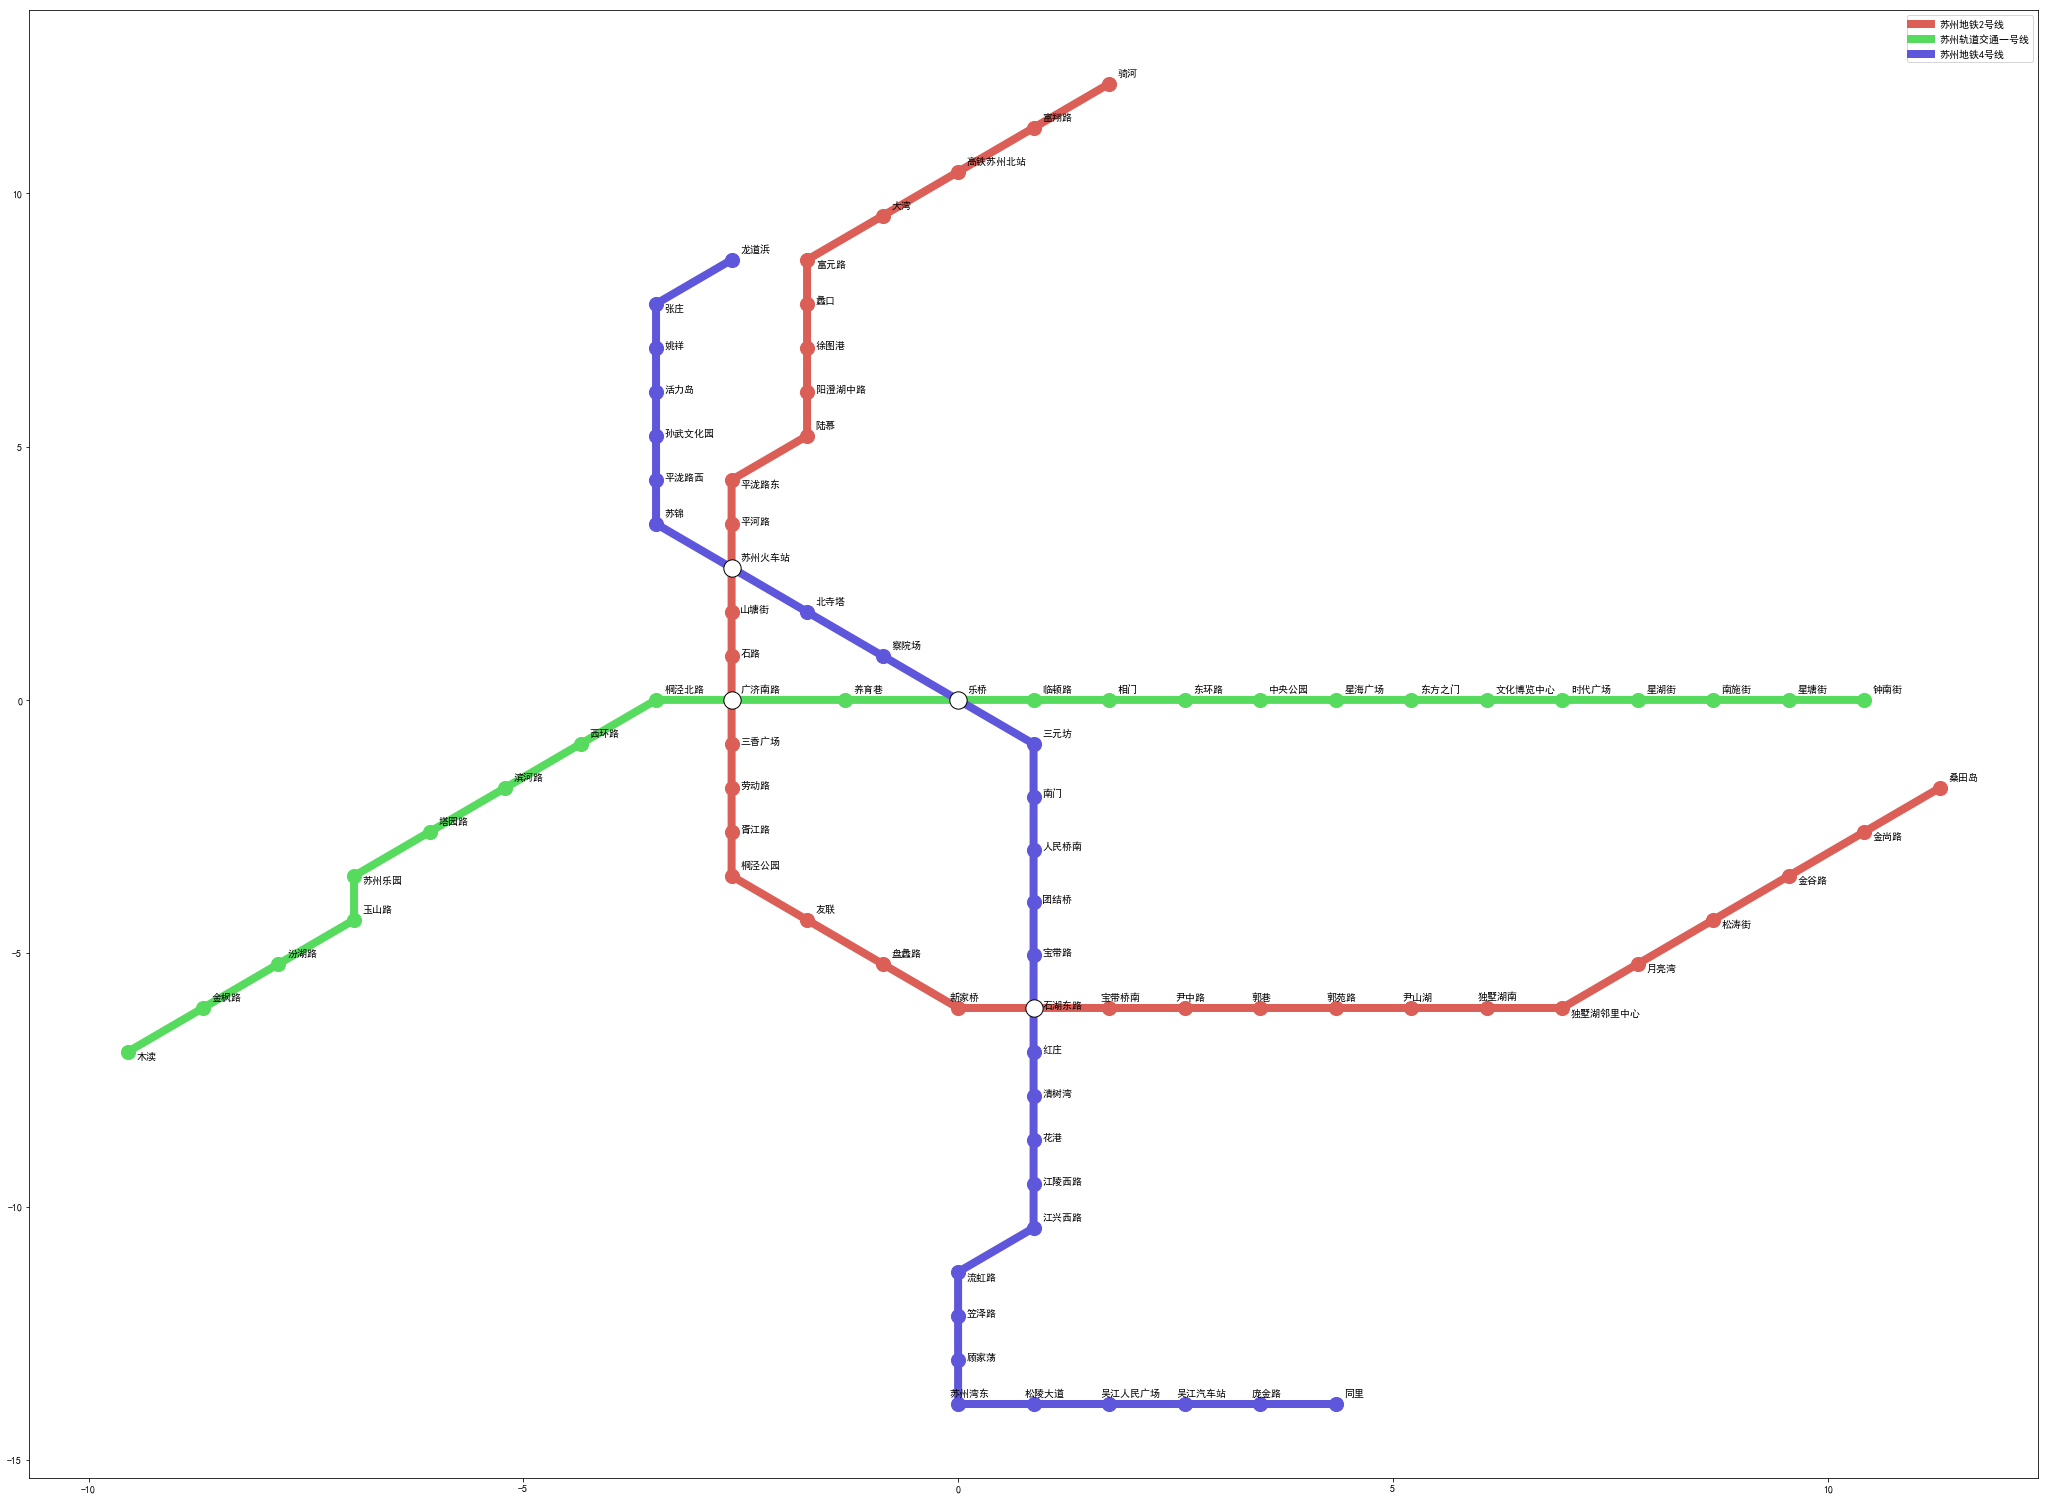

In [202]:
path = 'data/structured_data.json'
fig = plot_original(path)
out_path = 'data/output.svg'
final_fig = plot_final(out_path,path)